# Global Analytics

## Data

In [1]:
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MultiLabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

df = pd.read_excel('DSU-Dataset.xlsx')

df2 = df[df['High Cost Claim'].isna()]  # Save for submission
df = df[df['High Cost Claim'].notna()]

# Keep patients (by patient ID) either in train OR test, not both (data contamination)
# Some patients have a ton of high cost claims
unique_patients = df.drop_duplicates('Patient ID')
train_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=42)

train = df[df['Patient ID'].isin(train_patients['Patient ID'])]
train_X = train.drop(columns=['High Cost Claim'])
train_y = train['High Cost Claim']

test = df[df['Patient ID'].isin(test_patients['Patient ID'])]
test_X = test.drop(columns=['High Cost Claim'])
test_y = test['High Cost Claim']

## Data Engineering

In [2]:
def preprocess_icd10(X):
    return X.apply(lambda row: row.dropna().astype(np.int32).tolist(), axis=1)


def preprocess_modifiers(X):
    return X.fillna("").apply(lambda row: row.split(','))


class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = None

    def fit(self, X, y=None):
        self.mlb = MultiLabelBinarizer(sparse_output=True)
        self.mlb.fit(X)
        return self

    def transform(self, X):
        return self.mlb.transform(X)

    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_


icd10_pipeline = make_pipeline(
    FunctionTransformer(preprocess_icd10, validate=False,
                        feature_names_out='one-to-one'),
    MultiLabelBinarizerTransformer(),
)

modifier_pipeline = make_pipeline(
    FunctionTransformer(preprocess_modifiers, validate=False,
                        feature_names_out='one-to-one'),
    MultiLabelBinarizerTransformer(),
)

one_hot_pipeline = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='Nan'),
    # Could do a little more here ?
    # Using min_frequncy, could be optimized
    # 0% (no info loss), 0.1%, 0.5%, 1.0% is appropriate, may be different per feature
    OneHotEncoder(sparse_output=True, handle_unknown='ignore',
                  drop='if_binary', min_frequency=0.001),
)

# Dropping dates.
#  - The month/weekday of service date may be valuable.
#  - The date could be used to approximate inflation.
#     - I'll assume 'High Cost Claim' is inflation adjusted.
#  - Otherwise, this model would be used to predict dates in the future which would be harmful to performance

# Claim Subcategory and Claim Cateogry could be redundant

ct = ColumnTransformer([
    # 1. Select ICD10 columns, pass into the `icd10_pipeline`
    ('ICD10', icd10_pipeline, make_column_selector("^ICD10 Code \\d+$")),
    # 2. Split and One-Hot-Encode Modifiers column
    ("Modifiers", modifier_pipeline, 'Modifiers'),
    # 3. One-hot-encode other columns
    ('OneHot', one_hot_pipeline, [
        'Member Age',  # This could also be ordinal or numeric
        'Gender',
        'Marital Status',
        'Ethnicity',
        'LOB',
        'Network Status',
        'Claim Category',
        'Claim Subcategory',
        'Claim Line',
        'Place of Service',
        'Provider Type',
        'Provider Specialty',
        'Service Type',
        'Service Code',

    ]),
    # remainder="passthrough",
], n_jobs=-1, verbose=2)

## Model

In [3]:
pipeline = make_pipeline(
    LinearSVC(class_weight='balanced', max_iter=10000, dual=True, random_state=42),
    memory='cache', # Remove for prod
)

model = make_pipeline(
    # cannot pickle function transformer funcs
    # either this or prep outside pipe
    # this is pretty slow
    ct,
    GridSearchCV(
        pipeline,
        {
            'linearsvc__loss': ['squared_hinge'],
            'linearsvc__C': [0.0001, 0.0005, 0.001, 0.005,0.01, 0.05],
        },
        # We want an accurate distribution -> f1 or balanced_accuracy
        scoring='f1',
        n_jobs=-1,
        verbose=3,
        return_train_score=True,
    ),
)

model.fit(train_X, train_y)


print(f"Best parameters: {model.named_steps['gridsearchcv'].best_params_}")
print(f"Best cross-validation score: {model.named_steps['gridsearchcv'].best_score_}")


[ColumnTransformer] ..... (2 of 3) Processing Modifiers, total=   0.1s
[ColumnTransformer] ........ (3 of 3) Processing OneHot, total=   0.7s
[ColumnTransformer] ......... (1 of 3) Processing ICD10, total=   3.8s
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 4/5] END linearsvc__C=0.0001, linearsvc__loss=squared_hinge;, score=(train=0.665, test=0.663) total time=   0.5s
[CV 3/5] END linearsvc__C=0.0001, linearsvc__loss=squared_hinge;, score=(train=0.682, test=0.649) total time=   0.5s
[CV 2/5] END linearsvc__C=0.0001, linearsvc__loss=squared_hinge;, score=(train=0.691, test=0.651) total time=   0.5s
[CV 1/5] END linearsvc__C=0.001, linearsvc__loss=squared_hinge;, score=(train=0.872, test=0.690) total time=   0.4s
[CV 2/5] END linearsvc__C=0.001, linearsvc__loss=squared_hinge;, score=(train=0.852, test=0.752) total time=   0.3s
[CV 3/5] END linearsvc__C=0.001, linearsvc__loss=squared_hinge;, score=(train=0.831, test=0.763) total time=   0.4s
[CV 5/5] END linearsvc__C=0.

## Test Score

In [4]:
pred_y = model.predict(test_X)
print('test f1_score', f1_score(test_y, pred_y))
print('balanced_accuracy', balanced_accuracy_score(test_y, pred_y))

/opt/anaconda3/envs/datalab/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['AF', 'HW', 'Q7', 'QL', 'QM', 'TG', 'U1', 'U7'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/datalab/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/anaconda3/envs/datalab/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [9, 11, 13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


test f1_score 0.7822512049900765
balanced_accuracy 0.893094586388243


/opt/anaconda3/envs/datalab/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) [10022, 10044, 10046, 10049, 10051, 10055, 10058, 10059, 10061, 10062, 10069, 10070, 10077, 10091, 10097, 10102, 10104, 10110, 10154, 10162, 10165, 10167, 10178, 10189, 10193, 10201, 10219, 1022, 10231, 10234, 10238, 10243, 10255, 10265, 10268, 10273, 10291, 10297, 10298, 10305, 10307, 10312, 10326, 10327, 10341, 10352, 10365, 10376, 10384, 10387, 10388, 10393, 10397, 10411, 10412, 10413, 10441, 10442, 10444, 10448, 10449, 10452, 10454, 10464, 10466, 10467, 10475, 10476, 10477, 10480, 10506, 10507, 10510, 10511, 10514, 10521, 10525, 10533, 10541, 10544, 10545, 10560, 10562, 10567, 10569, 10574, 10578, 10581, 10582, 10589, 10593, 10597, 10612, 10613, 10616, 10623, 10625, 10626, 10648, 10649, 10650, 10651, 10652, 10653, 10654, 10664, 10665, 10666, 10670, 10676, 10697, 10699, 10704, 10709, 10712, 10713, 10718, 10719, 10723, 10725, 10726, 10727, 10732, 10733, 10738, 

## Results

In [9]:
X = df2.drop(columns=['High Cost Claim'])
df2['High Cost Claim'] = model.predict(X)

df2.to_csv('./sanford_results.csv', index=False)


/opt/anaconda3/envs/datalab/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['FT', 'GQ', 'GR', 'KD', 'KG', 'LM', 'QL', 'T9', 'U7'] will be ignored
  warnings.warn(
/opt/anaconda3/envs/datalab/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/anaconda3/envs/datalab/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3, 7, 9, 11, 13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/datalab/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) [10002, 10004, 10005, 10009, 10015, 10021, 10024, 10034, 10035, 1004, 10040, 10043, 10044, 1

## Precision Recall Curve

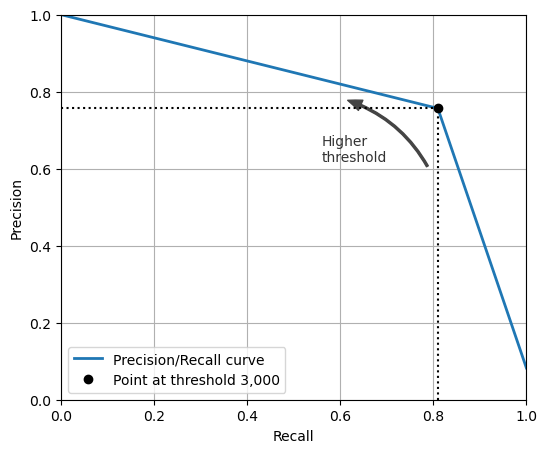

In [6]:
from sklearn.metrics import precision_recall_curve
import matplotlib.patches as patches
import matplotlib.pyplot as plt


precisions, recalls, thresholds = precision_recall_curve(test_y, pred_y)

threshold = 1
idx = (thresholds >= threshold).argmax()

plt.figure(figsize=(6, 5))

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()